In [1]:
import torch
print(torch.__version__)

2.5.1+cu124


In [2]:
import numpy as np
import os, copy, time, json, cv2, random
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.datasets.utils import download_and_extract_archive
import torchvision.transforms as T
from torchsummary import summary

import detectron2
from detectron2        import model_zoo
from detectron2.model_zoo.model_zoo import _ModelZooUrls
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import detection_utils as utils
from detectron2.utils.visualizer import Visualizer
from detectron2.data             import MetadataCatalog, DatasetCatalog
from detectron2.structures       import BoxMode
from detectron2.data.datasets    import register_coco_instances, load_coco_json
from detectron2.utils.logger     import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation       import COCOEvaluator, inference_on_dataset
from detectron2.data             import build_detection_test_loader, build_detection_train_loader
from detectron2.model_zoo.model_zoo import _ModelZooUrls
from tqdm.notebook import tqdm, trange

import pandas as pd

# from albumentations.pytorch import ToTensorV2
# import albumentations as A

import shutil
from urllib.request import urlretrieve

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION  = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

mz = _ModelZooUrls()
# print("\n".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

torch:  2.5 ; cuda:  cu124


In [3]:
# !pip install roboflow

# from roboflow import Roboflow
# project = rf.workspace("urfu-uavlq").project("stone_gen")
# version = project.version(3)
# dataset = version.download("coco-segmentation")

In [4]:
def get_stone_dict(pwd, anno_filename, img_catalog = ''):

    anno_file = anno_filename 
    print(anno_file)
    with open(anno_file) as f:
        data = json.load(f)
    
    dataset_dicts = []
    
    for img in data['images']:
        record = {}
    
        filename = os.path.basename(img["file_name"]).replace(":", "_")
        filename = os.path.join(img_catalog, filename)
        # print(filename)
        record["file_name"] = filename
        record["image_id"] = img['id']
        record["height"] = img['height']
        record["width"] = img['width']
    
        objs = []
        cnt = 0
        for anno in data['annotations']:
            if anno['image_id'] == record["image_id"]:
                obj = {
                        "bbox" : anno['bbox'],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        #"bbox_mode" : BoxMode.XYXY_ABS,
                        "segmentation": anno['segmentation'],
                        "category_id": 0, #anno['category_id'] - 1,
                        # anno['category_id'],
                        "iscrowd": 0,
                        }
                cnt += 1
                
                objs.append(obj)
                
        if cnt:
            record["annotations"] = objs
            dataset_dicts.append(record)

    
    return dataset_dicts

In [5]:
!ls open_pits


ls: cannot access 'open_pits': No such file or directory


In [28]:
# coco-segmentation/train/_annotations.coco.json
dataset_directory = "Stone_gen-3"
content = os.listdir(dataset_directory)

dataset_catalog_name_train = "stone_train"
dataset_catalog_name_valid = "stone_val"
dataset_catalog_name_test = "stone_test"

try:
    DatasetCatalog.pop(dataset_catalog_name_train)
except:
    pass

try:
    DatasetCatalog.pop(dataset_catalog_name_valid)
except:
    pass

try:
    DatasetCatalog.pop(dataset_catalog_name_test)
except:
    pass

dataset_train_pwd = os.path.join(dataset_directory, 'train')
dataset_valid_pwd = os.path.join(dataset_directory, 'valid')
dataset_test_pwd = os.path.join(dataset_directory, 'test')

try:
    DatasetCatalog.register(dataset_catalog_name_train, lambda : get_stone_dict(dataset_train_pwd, 'Stone_gen-3/train/_annotations.coco.json', 'Stone_gen-3/train'))
except:
    print(f'Probably data {traint_dataset_pwd} have been already registred')

try:
    DatasetCatalog.register(dataset_catalog_name_valid, lambda : get_stone_dict(dataset_valid_pwd, 'Stone_gen-3/valid/_annotations.coco.json', 'Stone_gen-3/valid'))
except:
    print(f'Probably data {traint_dataset_val_pwd} have been already registred')

try:
    DatasetCatalog.register(dataset_catalog_name_test, lambda : get_stone_dict(dataset_test_pwd, 'Stone_gen-3/test/_annotations.coco.json', 'Stone_gen-3/test'))
except:
    print(f'Probably data {dataset_test_pwd} have been already registred')

In [29]:
MetadataCatalog.get(dataset_catalog_name_train).set(thing_classes=["stone"])
MetadataCatalog.get(dataset_catalog_name_valid).set(thing_classes=["stone"])
MetadataCatalog.get(dataset_catalog_name_test).set(thing_classes=["stone"])

namespace(name='stone_test', thing_classes=['stone'])

In [30]:
stone_train_metadata = MetadataCatalog.get("stone_train")
dataset_train_dicts = get_stone_dict(dataset_train_pwd, 'Stone_gen-3/train/_annotations.coco.json', 'Stone_gen-3/train')

Stone_gen-3/train/_annotations.coco.json


### Check out

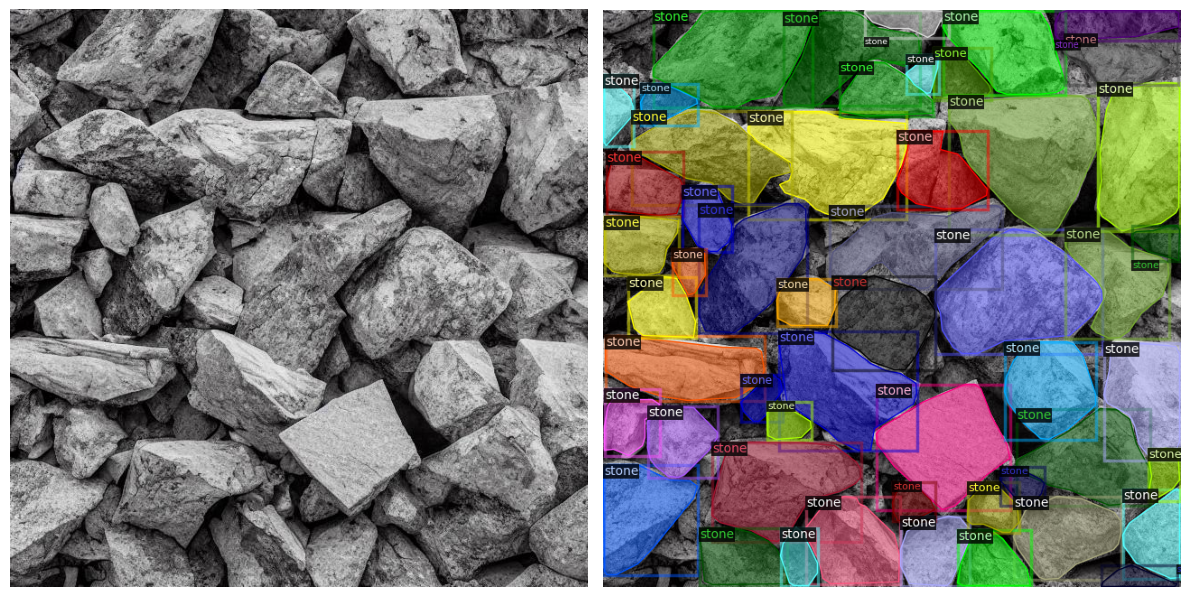

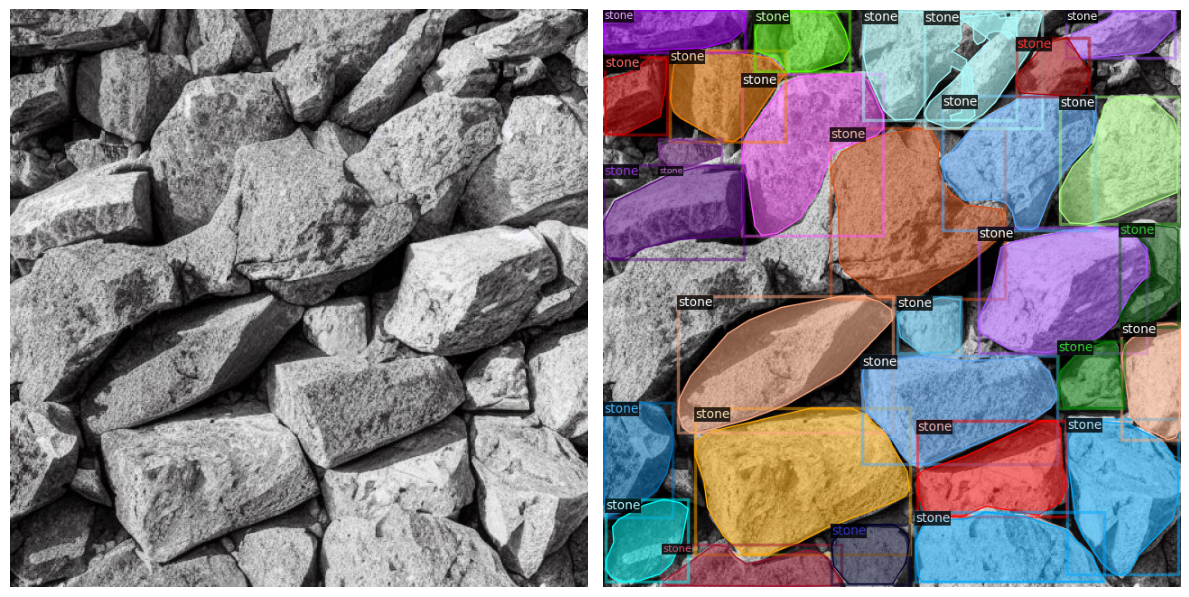

In [31]:
for d in random.sample(dataset_train_dicts, 2):
    img   = Image.open(d["file_name"])
    rgb_im = img.convert('RGB')
    _,axs = plt.subplots(1,2,figsize=(12,8))
    axs[0].imshow(rgb_im); axs[0].axis('off')
    visualizer = Visualizer(rgb_im, metadata=stone_train_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[1].imshow(out.get_image()); axs[1].axis('off')
    plt.tight_layout();plt.show()

# Train

In [32]:
import detectron2.data.transforms as T
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
                        T.Resize((800,600)),
                        T.RandomBrightness(0.8, 1.8),
                        T.RandomContrast(0.6, 1.3),
                        T.RandomSaturation(0.8, 1.4),
                        T.RandomRotation(angle=[90, 90]),
                        T.RandomLighting(0.7),
                        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
                    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]

    instances = utils.annotations_to_instances(annos, image.shape[:2])

    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict



### Config

In [33]:
from detectron2.config import CfgNode, LazyConfig, get_cfg, instantiate
import pkg_resources

In [34]:
from detectron2.data import get_detection_dataset_dicts
import json

In [35]:
BATCH = 2

cfg = get_cfg()

model_config = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"


cfg.merge_from_file(model_zoo.get_config_file(model_config))

cfg.DATASETS.TRAIN = ("stone_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

cfg.DATASETS.TEST = ("stone_val",)
cfg.TEST.EVAL_PERIOD = 500

# ДООБУЧЕНИЕ!!!!
# cfg.MODEL.WEIGHTS = "output/model_final.pth_3"


### Multiprocessing

In [36]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [37]:
cfg.OUTPUT_DIR

'./output'

In [39]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True);
trainer = CustomTrainer(cfg)
# trainer = DefaultTrainer(cfg);


[12/02 18:28:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# ДООБУЧЕНИЕ!

In [ ]:
# trainer.resume_or_load(resume=False)  # Установите resume=False, чтобы начать дообучение

# TRAIN IT

In [ ]:
trainer.train()

[12/02 18:29:51 d2.engine.train_loop]: Starting training from iteration 0
[12/02 18:30:16 d2.utils.events]:  eta: 0:17:50  iter: 19  total_loss: 2.437  loss_cls: 0.6749  loss_box_reg: 0.1258  loss_mask: 0.6933  loss_rpn_cls: 0.6948  loss_rpn_loc: 0.2698    time: 1.0923  last_time: 1.0973  data_time: 0.1586  last_data_time: 0.0063   lr: 4.9953e-06  max_mem: 5183M
[12/02 18:30:37 d2.utils.events]:  eta: 0:17:29  iter: 39  total_loss: 2.388  loss_cls: 0.6653  loss_box_reg: 0.06937  loss_mask: 0.6932  loss_rpn_cls: 0.6951  loss_rpn_loc: 0.2538    time: 1.0905  last_time: 1.0881  data_time: 0.0059  last_data_time: 0.0059   lr: 9.9902e-06  max_mem: 5185M
[12/02 18:30:59 d2.utils.events]:  eta: 0:17:07  iter: 59  total_loss: 2.413  loss_cls: 0.6401  loss_box_reg: 0.1284  loss_mask: 0.693  loss_rpn_cls: 0.6946  loss_rpn_loc: 0.2527    time: 1.0903  last_time: 1.0902  data_time: 0.0057  last_data_time: 0.0053   lr: 1.4985e-05  max_mem: 5185M
[12/02 18:31:21 d2.utils.events]:  eta: 0:16:46  iter

# VALIDATE

In [75]:
cfg.OUTPUT_DIR

'./output'

In [100]:
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import BoxMode, PolygonMasks

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("stone_valid")
predictor = DefaultPredictor(cfg)


[12/02 17:52:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [ ]:
stone_test_metadata = MetadataCatalog.get("stone_test")
dataset_test_dicts = get_stone_dict(dataset_test_pwd, 'Stone_gen-3/test/_annotations.coco.json', 'Stone_gen-3/test')

In [97]:
# !mkdir -p pred/val

Stone_gen-3/valid/image_1051_png.rf.d4377dda6444c9d9cb78cfad0e9c8dcf.jpg
Stone_gen-3/valid/image_1301_png.rf.9074dd15adc4fa7a7b3f060b99f793a2.jpg


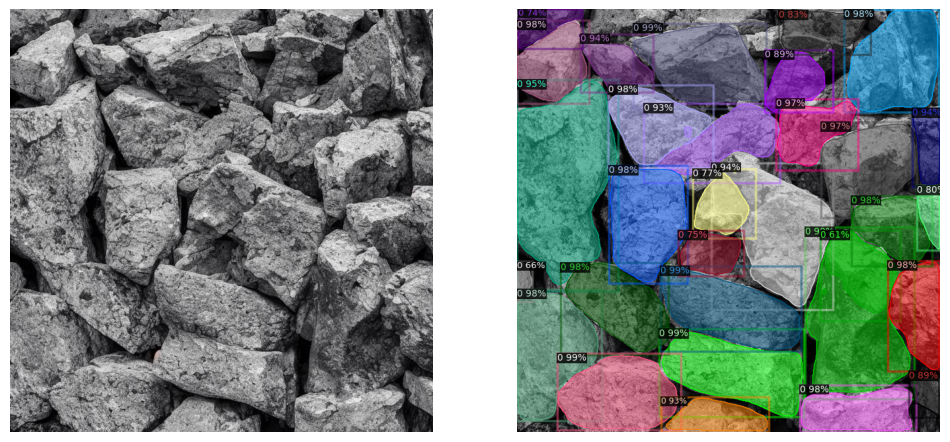

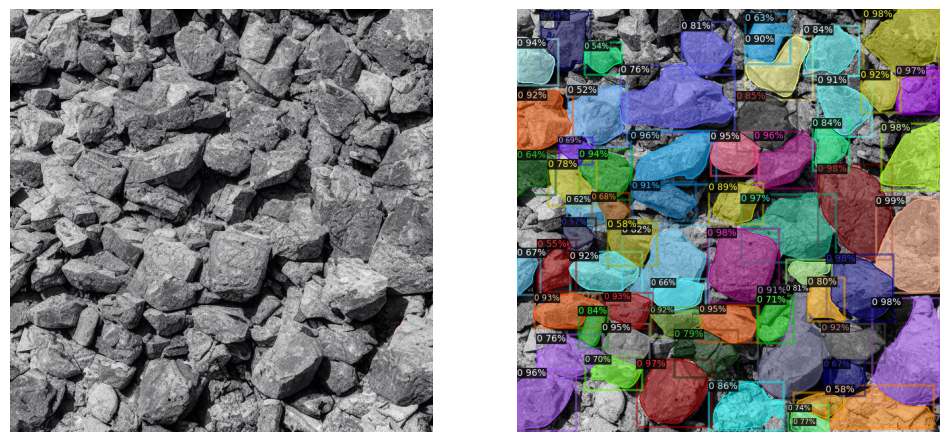

In [98]:
for d in random.sample(dataset_valid_dicts, 2):
#for d in dataset_valid_dicts:
    print(d["file_name"])
    img   = cv2.imread(d["file_name"])

    _,axs = plt.subplots(1,2,figsize=(12,8))
    axs[0].imshow(img); axs[0].axis('off')

    outputs = predictor(img)
    # print(outputs)
    v = Visualizer(img, 
                    metadata=stone_valid_metadata, 
                    scale=1
                  )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # plt.imsave('pred/' + d["file_name"], out.get_image())
    
    axs[1].imshow(out.get_image())
    axs[1].axis('off')
    #print(outputs)
    
plt.show()

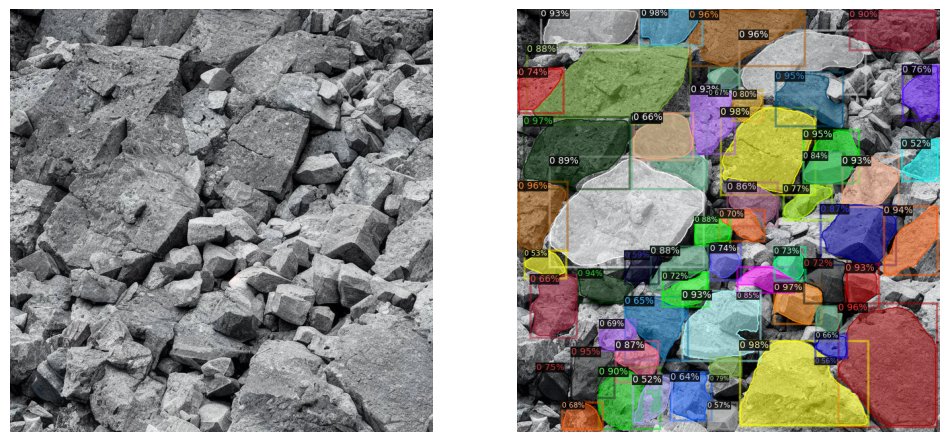

In [102]:
test_filename = 'Stone_gen-3/valid/image_1538_png.rf.d066fd6b26f61e25d59ee30b6e54354b.jpg'

img   = cv2.imread(test_filename)

_,axs = plt.subplots(1,2,figsize=(12,8))
axs[0].imshow(img); axs[0].axis('off')

outputs = predictor(img)
# print(outputs)
v = Visualizer(img, 
                metadata=stone_valid_metadata, 
                scale=1
              )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# plt.imsave('pred/' + d["file_name"], out.get_image())

axs[1].imshow(out.get_image())
axs[1].axis('off')
#print(outputs)
    
plt.show()

### EVALUATOR

In [82]:
!pip install -q coco_eval

In [127]:
stone_test_metadata = MetadataCatalog.get("stone_test")

In [128]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("stone_val", output_dir="./output")
# val_loader = build_detection_test_loader(cfg, "stone_val")
# print(inference_on_dataset(predictor.model, val_loader, evaluator))

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("stone_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "stone_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

FileNotFoundError: [Errno 2] No such file or directory: './output/stone_test_coco_format.json'